In [1]:
import configparser
import os.path
from alpenglow.image_sources.s3 import S3ImageSource

path_format = '76AO/Strips/im_{stripe_id:06d}_{version_id:06d}.tif'
stripe_ids = [27, 28, 29, 30, 31, 32]
version_ids = list(range(1, 129))

config_parser = configparser.ConfigParser()
config_parser.read_file(open(os.path.join(os.path.expanduser('~'), '.aws', 'credentials')))
config_parser.sections()

aws_access_key_id = config_parser.get('default', 'AWS_ACCESS_KEY_ID')
aws_secret_access_key = config_parser.get('default', 'AWS_SECRET_ACCESS_KEY')

array_mapping = lambda a: a

image_source = S3ImageSource(path_format, stripe_ids, version_ids, aws_access_key_id, aws_secret_access_key, 'alpenglowoptics', 'https://s3.amazonaws.com', array_mapping=array_mapping)
print("configuration read")

configuration read


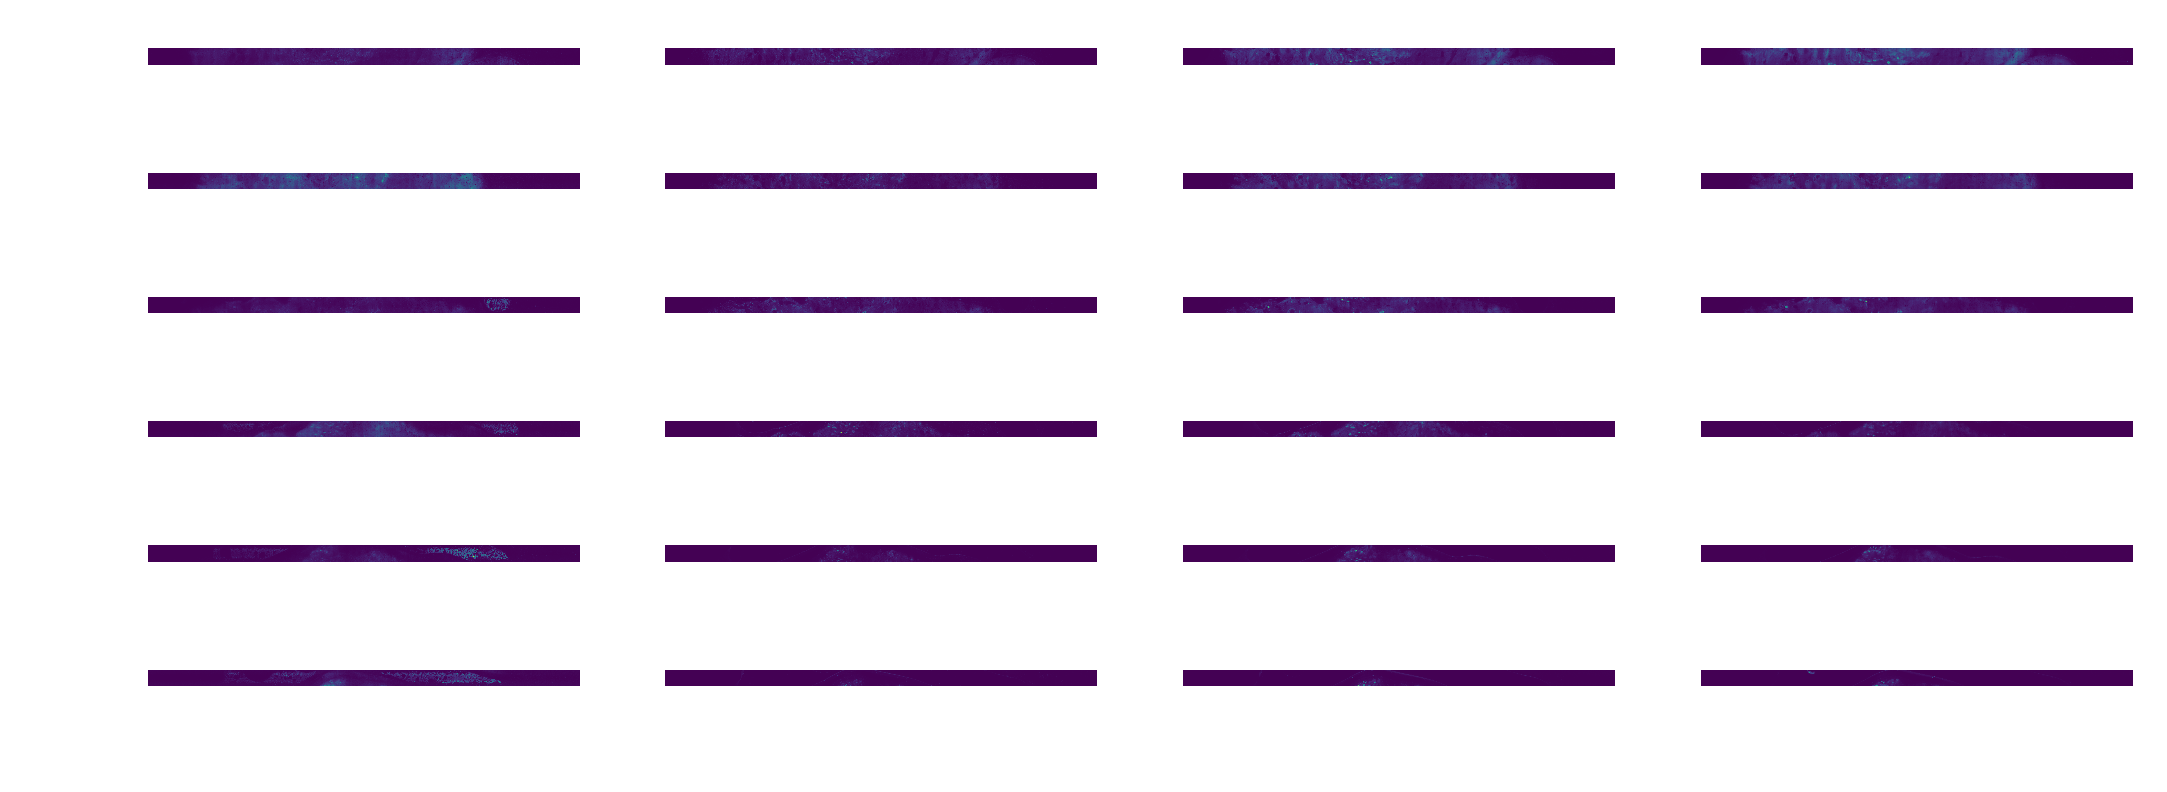

Average sample fetch time: 2.91017845273
estimated required time 2235.0170517


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import concurrent

from time import time
start_time=time()

demo_versions = [16, 48, 80, 112]
demo_stripes = list(range(len(stripe_ids)))

fig = plt.figure(figsize=(8, 3), dpi=320)
future_to_position = {}
for version_index, version_id in enumerate(demo_versions, 1):
    for stripe_index, stripe_id in enumerate(demo_stripes, 0):
        future_to_position[image_source.get_image_future(stripe_id, version_id - 1)] = version_index + len(demo_versions) * stripe_index
        
for future in concurrent.futures.as_completed(future_to_position):
    ax = fig.add_subplot(len(demo_stripes), len(demo_versions), future_to_position[future])
    ax.imshow(future.result())
    ax.set_axis_off()
plt.show()

avg_image_fetch_time = (time() - start_time)/(len(demo_versions) * len(demo_stripes))
print("Average sample fetch time: {0}\nestimated required time {1}".format(avg_image_fetch_time, avg_image_fetch_time * len(demo_stripes) * len(version_ids)))

In [4]:
from alpenglow.matching_algorithms.fft import FftMatchingAlgorithm
matching_algorithm = FftMatchingAlgorithm(list(range(8, 127, 16)), [0])

In [5]:
from alpenglow.patchwork_builders.lazy import LazyPatchworkBuilder
from alpenglow.image_sources.benchmarking import BenchmarkingImageSource

benchmarking_image_source = BenchmarkingImageSource(image_source)
from time import time
start_time=time()

builder = LazyPatchworkBuilder(matching_algorithm)
for stripe_id in range(6):
    builder.stitch(benchmarking_image_source.get_stripe(stripe_id))

patchwork = builder.get()

print("total time: {0}s".format(time() - start_time))
stitching_times = builder.benchmark()
print("stitching times: {0}".format(stitching_times))
print("image fetching time: {0}".format(benchmarking_image_source.total_fetching_time()))

total time: 558.268450975s
stitching times: [9.5367431640625e-07, 126.43186402320862, 108.13842511177063, 102.01669502258301, 103.60534191131592, 118.05886483192444]
image fetching time: 2012.93176961


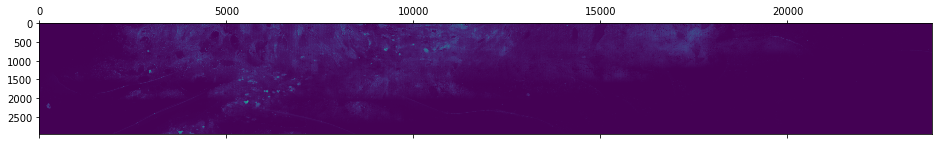

In [6]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.matshow(patchwork[64, :, :])
plt.show()